In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import theano.tensor as tt
import matplotlib.pyplot as plt
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
az.style.use('arviz-darkgrid')

In [3]:
np.random.seed(42)

([], [])

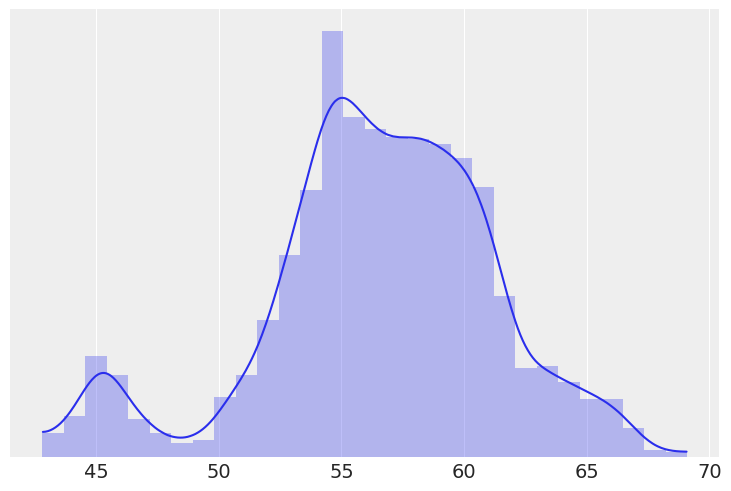

In [4]:
cs = pd.read_csv('data/chemical_shifts_theo_exp.csv')
cs_exp = cs['exp']
az.plot_kde(cs_exp)
plt.hist(cs_exp, density=True, bins=30, alpha=0.3)
plt.yticks([])

즉 다음과 같이 도수분포표과 있을때, 이를 Kernel Density Estimation을 통해 여러 가우시안 분포함수들을 더하여 확률분포함수를 근사할 수 있다.

## The Dirichlet distribution

In [5]:
cluster = 2
with pm.Model() as model_mg:
    p = pm.Dirichlet('p', a = np.ones(cluster))
    # a를 통해 concentration parameter 지정
    means = pm.Normal('means', mu=cs_exp.mean(), sd = 10, shape = cluster)
    sd = pm.HalfNormal('sd', sd = 10)
    y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed = cs_exp)
    idata_mg = pm.sample(random_seed=123, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


다음과 같이 pm.NormalMixture()를 통해 Gaussian mixture 사용가능

array([[<AxesSubplot:title={'center':'means'}>,
        <AxesSubplot:title={'center':'means'}>],
       [<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>]], dtype=object)

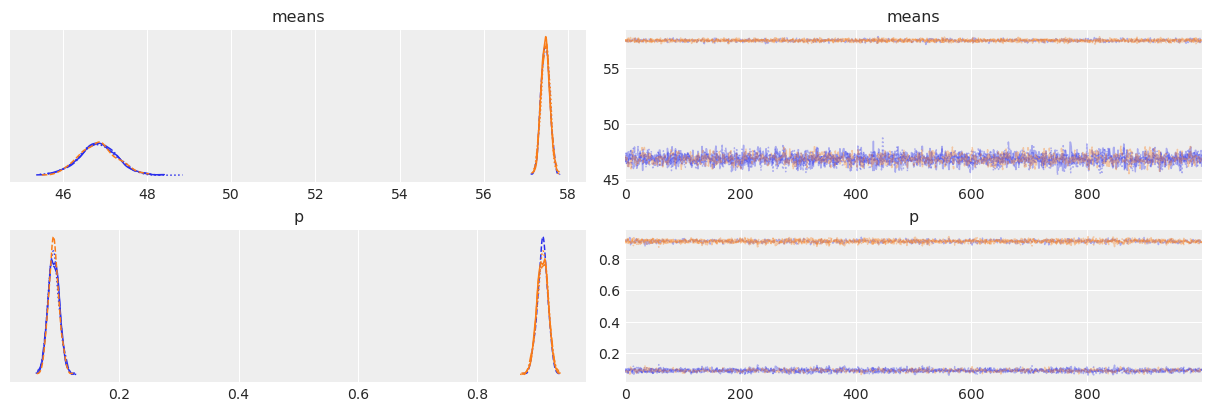

In [6]:
varnames = ['means', 'p']
az.plot_trace(idata_mg, varnames)

In [7]:
az.summary(idata_mg, varnames)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
means[0],49.494,4.618,46.176,57.665,2.292,1.755,7.0,31.0,1.53
means[1],54.807,4.609,46.478,57.700,2.293,1.755,7.0,28.0,1.53
p[0],0.295,0.355,0.074,0.919,0.177,0.135,7.0,30.0,1.53
p[1],0.705,0.355,0.081,0.926,0.177,0.135,7.0,30.0,1.53


plot_trace를 보면 알겠지만, 둘의 평균이 갈리는 것 같지만, summary를 보면 means의 평균이 같다.  
즉 parameter non-identifiability 가 발생했다.  
가능한한 모델은 non-identifiability를 제거하여야 한다.

## Non-identifiability of mixture models

In [8]:
cluster = 2
with pm.Model() as model_mgp:
    p = pm.Dirichlet('p', a = np.ones(cluster))
    means = pm.Normal('means', mu=np.array([.9, 1])*cs_exp.mean(), sd = 10, shape = cluster)
    sd = pm.HalfNormal('sd', sd = 10)
    order_means = pm.Potential('order_means', tt.switch(means[1] - means[0] < 0, -np.inf, 0))
    # pm.Potential()를 통해 분포들에 순서를 가할 수 있다. 여기서는 평균으로 해당 구분하여 해당 숫자들에 대해
    # 0과 -inf를 구분하여 분포를 구분하였다.
    y = pm.NormalMixture('y', w = p, mu=means, sd = sd, observed = cs_exp)
    idata_mgp = pm.sample(1000, random_seed=123, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.


array([[<AxesSubplot:title={'center':'means'}>,
        <AxesSubplot:title={'center':'means'}>],
       [<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>]], dtype=object)

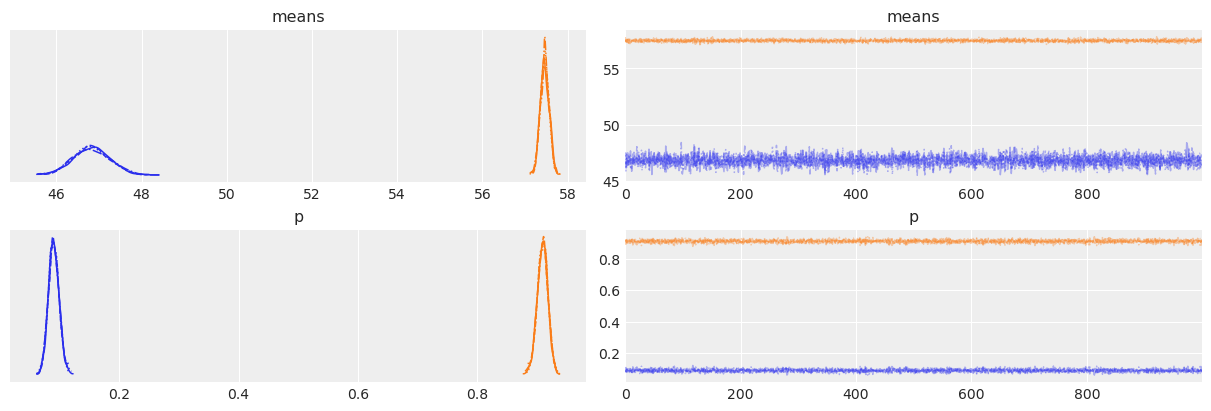

In [9]:
varnames = ['means', 'p']
az.plot_trace(idata_mgp, varnames)

In [10]:
az.summary(idata_mgp)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
means[0],46.821,0.431,46.017,47.615,0.007,0.005,4029.0,3466.0,1.0
means[1],57.463,0.103,57.276,57.654,0.002,0.001,4622.0,2892.0,1.0
p[0],0.090,0.009,0.073,0.107,0.000,0.000,3813.0,2899.0,1.0
p[1],0.910,0.009,0.893,0.927,0.000,0.000,3813.0,2899.0,1.0
sd,3.653,0.076,3.508,3.795,0.001,0.001,4517.0,3138.0,1.0


## How to choose K

In [11]:
clusters = [3, 4, 5, 6]
models = []
idatas = []
for cluster in clusters:
    with pm.Model() as model:
        p = pm.Dirichlet('p', a = np.ones(cluster))
        means = pm.Normal('means',mu = np.linspace(cs_exp.min(), cs_exp.max(), cluster), sd = 10, shape = cluster,
                         transform = pm.distributions.transforms.ordered)
        sd = pm.HalfNormal('sd', sd = 10)
        y = pm.NormalMixture('y', w = p, mu = means, sd = sd, observed = cs_exp)
        idata = pm.sample(1000, tune = 2000, target_accept = 0.9, random_seed=123, return_inferencedata=True)
        idatas.append(idata)
        models.append(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 91 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 98 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 211 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 449 seconds.
There were 159 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.422806916656984, but should be close to 0.9. Try to increase the number of tuning steps.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


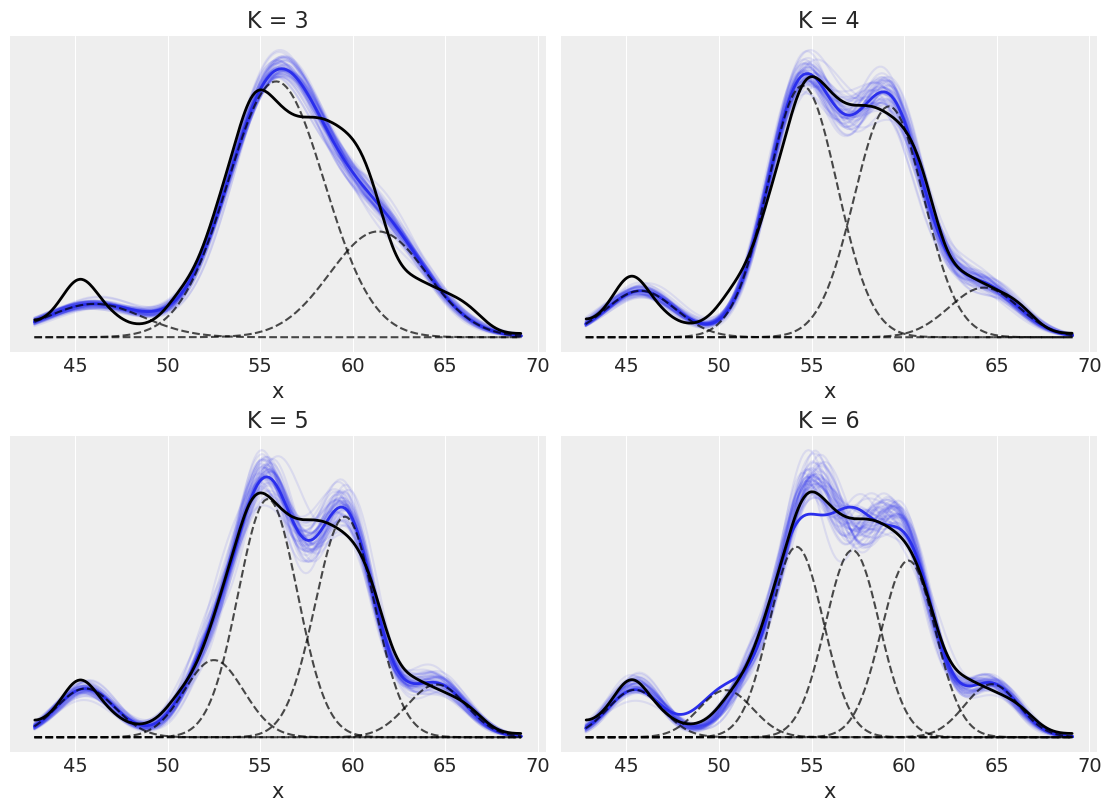

In [12]:
_, ax = plt.subplots(2, 2, figsize=(11, 8), constrained_layout=True)
 
ax = np.ravel(ax)
x = np.linspace(cs_exp.min(), cs_exp.max(), 200)
for idx, idata_x in enumerate(idatas):
    posterior_x = idata_x.posterior.stack(samples=("chain", "draw"))
    x_ = np.array([x] * clusters[idx]).T
 
    for i in range(50):
        i_ = np.random.randint(0, posterior_x.samples.size)
        means_y = posterior_x['means'][:,i_]
        p_y = posterior_x['p'][:,i_]
        sd = posterior_x['sd'][i_]
        dist = stats.norm(means_y, sd)
        ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y.values, 1), 'C0', alpha=0.1)
 
    means_y = posterior_x['means'].mean("samples")
    p_y = posterior_x['p'].mean("samples")
    sd = posterior_x['sd'].mean()
    dist = stats.norm(means_y, sd)
    ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y.values, 1), 'C0', lw=2)
    ax[idx].plot(x, dist.pdf(x_) * p_y.values, 'k--', alpha=0.7)
         
    az.plot_kde(cs_exp, plot_kwargs={'linewidth':2, 'color':'k'}, ax=ax[idx])
    ax[idx].set_title('K = {}'.format(clusters[idx]))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel('x')

In [13]:
ppc_mm = [pm.sample_posterior_predictive(idatas[i], 1000, models[i])
         for i in range(4)]

C:\Anaconda3\envs\pymc_env\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


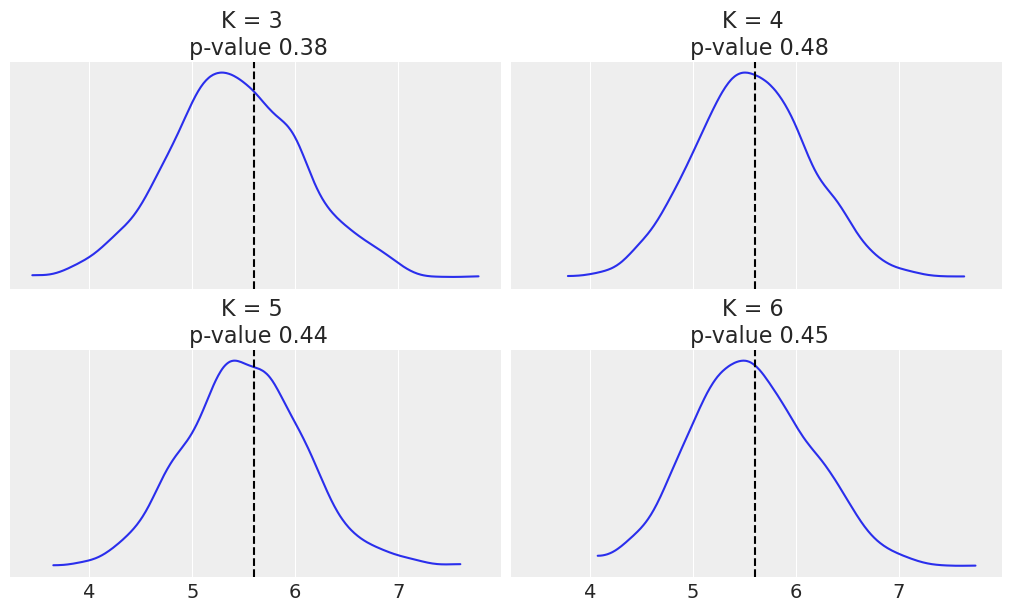

In [14]:
fig, ax = plt.subplots(2, 2, figsize = (10, 6), sharex=True, constrained_layout = True)
ax = np.ravel(ax)
def iqr(x, a = 0):
    return np.subtract(*np.percentile(x, [75, 25], axis=a))

T_obs = iqr(cs_exp) # iqr 방법을 통한 이상치 제거
for idx, d_sim in enumerate(ppc_mm):
    T_sim = iqr(d_sim['y'][:100].T, 1)
    p_value = np.mean(T_sim >= T_obs)
    az.plot_kde(T_sim, ax=ax[idx])
    ax[idx].axvline(T_obs, 0, 1, color = 'k', ls = '--')
    ax[idx].set_title(f'K = {clusters[idx]} \n p-value {p_value:.2f}')
    ax[idx].set_yticks([])

In [15]:
comp = az.compare(dict(zip([str(c) for c in clusters], idatas)),
                 method='BB-pseudo-BMA', ic='waic', scale = 'deviance')
comp

C:\Anaconda3\envs\pymc_env\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
C:\Anaconda3\envs\pymc_env\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
C:\Anaconda3\envs\pymc_env\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
C:\Anaconda3\envs\pymc_env\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The frame.append method is deprecated and

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
6,0,10251.655876,12.320675,0.000000,9.125400e-01,63.173331,0.000000,False,deviance
5,1,10258.891454,10.126313,7.235578,8.503904e-02,61.382129,3.800239,False,deviance
4,2,10279.031416,7.561068,27.375540,2.420994e-03,60.642637,9.252588,False,deviance
3,3,10356.765531,5.856399,105.109656,6.481359e-13,60.631617,18.309559,False,deviance


<AxesSubplot:xlabel='Deviance'>

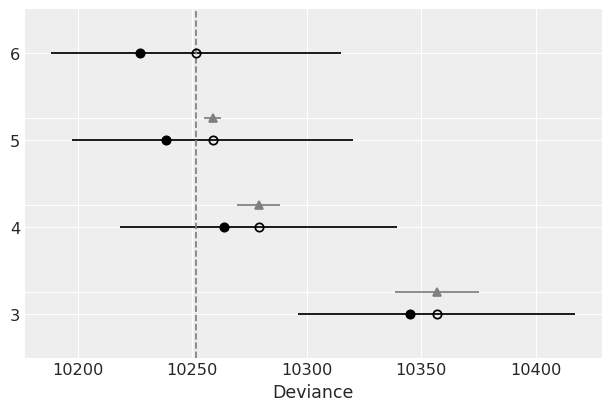

In [16]:
az.plot_compare(comp)

비교를 해보면 k가 6일때 waic가 제일 작고, plot_compare 상에서도 제일 작은 것이 분명하다.

## Non-finite mixture model

Dirichlet Process 중 Stick_breaking process 구현

In [17]:
def stick_breaking_truncated(α, H, K):
    """
    alpha : concentration parameter
    0일수록 생성된 분포가 discrete 하고 무한대에 가까울수록 연속분포에 가까움
    H : scipy에 의해 생성된 분포.Base 분포
    K : int. componenet의 개수
    return
    ---------------
    locs : array형태
    sbt process는 기본적으로 결과가 discrete 분포인데, 이때 막대의 위치가 필요하다.
    w : array 형태
    각각 막대의 높이. 즉 확률을 의미
    """
    βs = stats.beta.rvs(1, α, size=K) # 확률에 대한 분포 : beta분포를 이용
    w = np.empty(K)
    w = βs * np.concatenate(([1.], np.cumprod(1 - βs[:-1])))
    # cumprod를 하는 경우 누적 곱하기 합이 나온다.예를 들어 [1, 2, 3, 4]이면 24가 나옴.
    locs = H.rvs(size = K) # Base 분포를 이용하여 도수분포표 막대 위치 샘플링
    return locs, w

In [18]:
K = 500
H = stats.norm
alphas = [1, 10, 100, 1000]

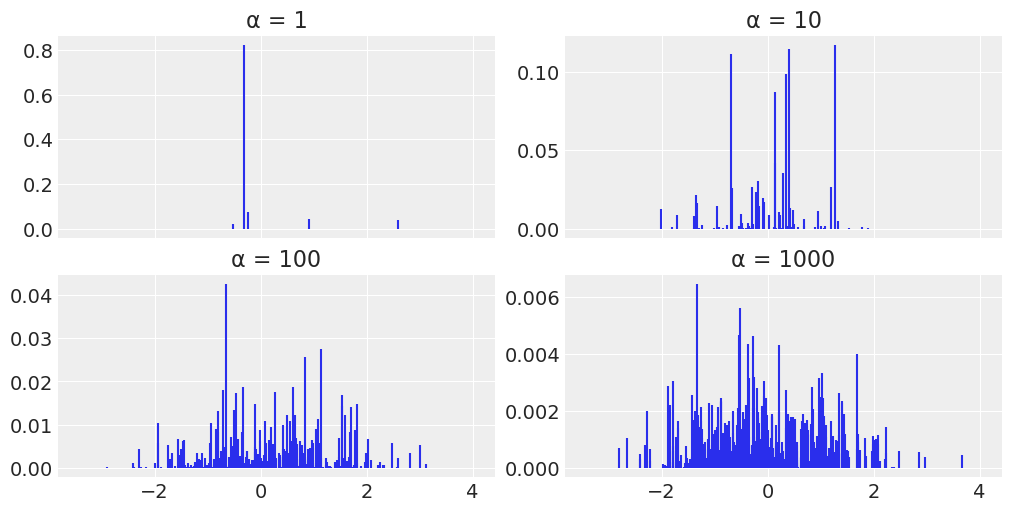

In [19]:
_, ax = plt.subplots(2, 2, sharex=True, figsize = (10, 5))
ax = np.ravel(ax) # 다차원 배열을 1차원으로 바꿔줌.
for idx, α in enumerate(alphas):
    locs, w = stick_breaking_truncated(α, H, K)
    ax[idx].vlines(locs, 0, w, color = 'C0')
    ax[idx].set_title(f'α = {α}')

In [20]:
α = 10
H = stats.norm
K = 5

In [21]:
x = np.linspace(-4, 4, 250)
x_ = np.array([x] * K).T
locs, w = stick_breaking_truncated(α, H, K)

([], [])

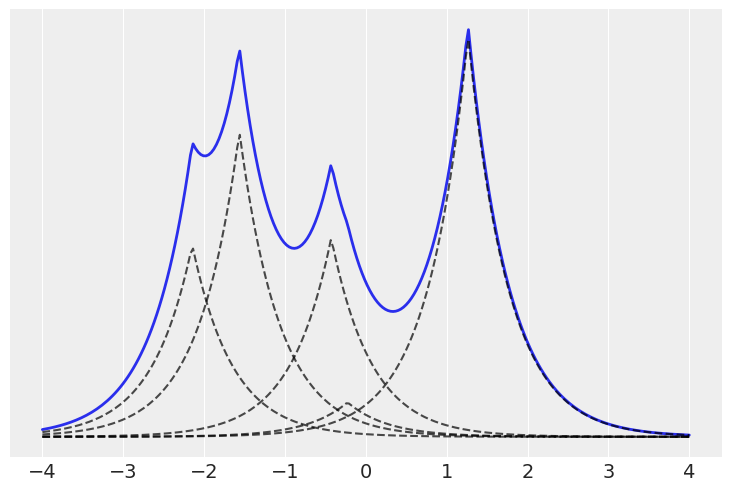

In [22]:
dist = stats.laplace(locs, 0.5)
plt.plot(x, np.sum(dist.pdf(x_) * w, 1), 'C0', lw=2)
plt.plot(x, dist.pdf(x_) * w, 'k--', alpha=0.7)
plt.yticks([])

라플라스 분포를 이용하여 분포 생성.  
무조건 정규분포로 할 필요는 없다.

In [23]:
K = 20
def stick_breaking(α, K):
    β = pm.Beta('β', 1., α, shape = K)
    w = β*pm.math.concatenate([[1.], tt.extra_ops.cumprod(1.-β)[:-1]])
    return w

In [24]:
with pm.Model() as model:
    α = pm.Gamma('α', 1., 1.)
    w = pm.Deterministic('w', stick_breaking(α, K))
    means = pm.Normal('means', 
                     mu = np.linspace(cs_exp.min(), cs_exp.max(), K),
                     sd = 10, shape = K)
    
    sd = pm.HalfNormal('sd', sd = 10, shape = K)
    obs = pm.NormalMixture('obs', w, means, sd = sd, observed = cs_exp.values)
    idata = pm.sample(1000, tune = 2000, target_accept = 0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, β, α]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 3236 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8427064204558928, but should be close to 0.95. Try to increase the number of tuning steps.
There were 544 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.12429145648621535, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>]], dtype=object)

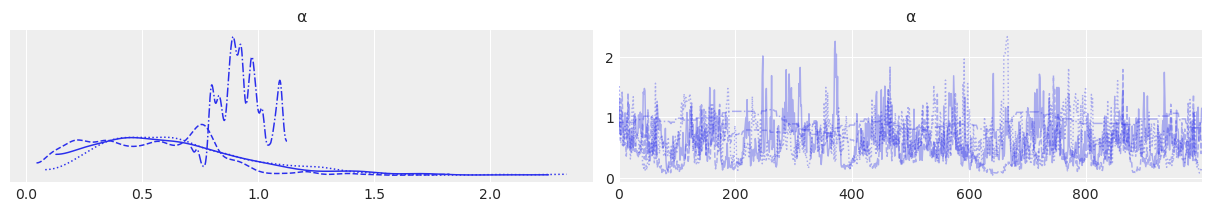

In [25]:
az.plot_trace(idata, var_names = ['α'], divergences = False)

Text(0, 0.5, 'Average weight')

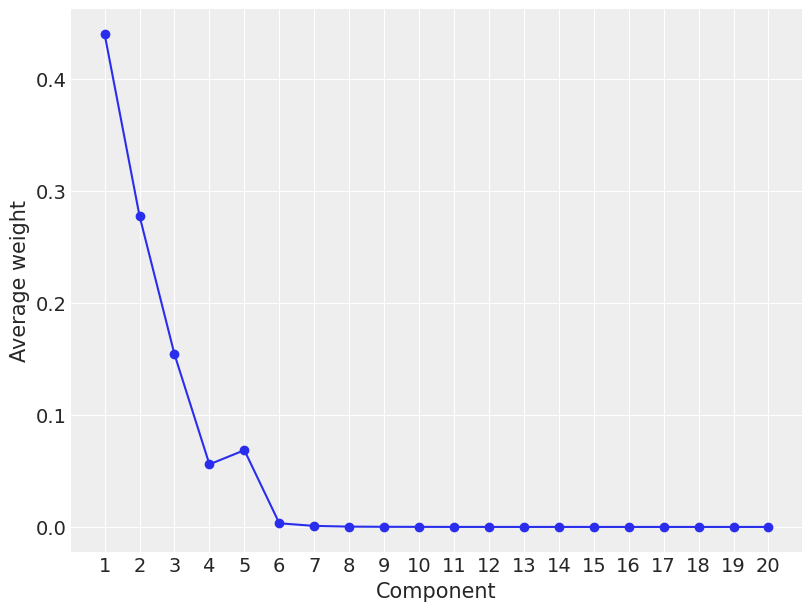

In [26]:
plt.figure(figsize=(8, 6))
plot_w = np.arange(K)
plt.plot(plot_w, idata.posterior['w'].mean(("chain", "draw")), 'o-')
plt.xticks(plot_w, plot_w+1)
plt.xlabel('Component')
plt.ylabel('Average weight')

보면 알다싶이 k = 4까지 유의미하고, 5 이후론 대부분 값들이 0으로 수렴해서 20은 너무 k값으로 큰 값이었다.

In [28]:
x_plot = np.linspace(cs_exp.min()-1, cs_exp.max()+1, 200)

posterior = idata.posterior.stack(samples = ('chain', 'draw'))

post_pdf_contribs = stats.norm.pdf(np.atleast_3d(x_plot),
                                  posterior['means'].values[:, np.newaxis, :],
                                  posterior['sd'].values[:, np.newaxis, :])

post_pdfs = (posterior['w'].values[:, np.newaxis, :]* post_pdf_contribs).sum(axis=0)

w와 해당하는 normal distribution들을 곱하여 새로운 분포를 만들어냈다.

([], [])

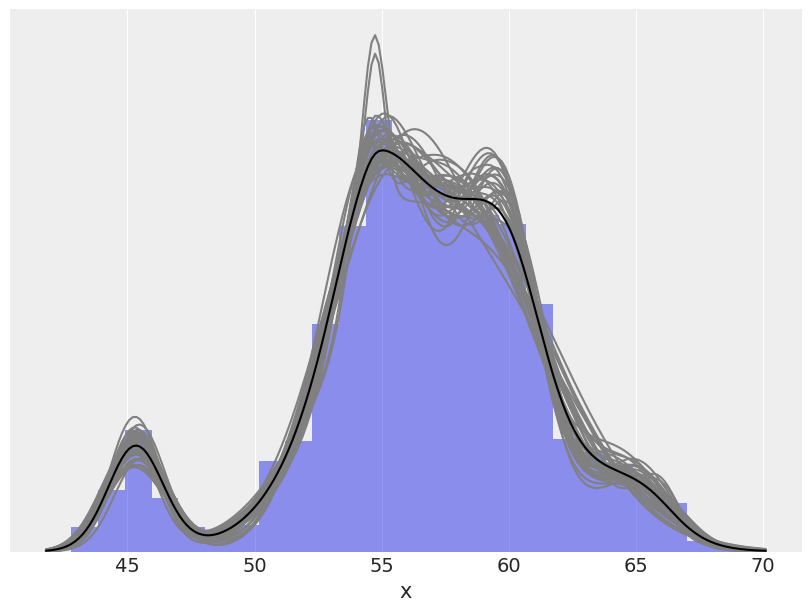

In [29]:
plt.figure(figsize=(8, 6))

plt.hist(cs_exp.values, bins=25, density=True, alpha=0.5)
plt.plot(x_plot, post_pdfs[:,::100], c='0.5')
plt.plot(x_plot, post_pdfs.mean(axis=1), c='k')

plt.xlabel('x')
plt.yticks([])